### Day 13: Transparent Origami

In [9]:
sample = """
6,10
0,14
9,10
0,3
10,4
4,11
6,0
6,12
4,1
0,13
10,12
3,4
3,0
8,4
1,10
2,14
8,10
9,0

fold along y=7
fold along x=5""".strip().split('\n')

In [99]:
import numpy as np

def parse_transparent_paper(lines):
    dots, folds = [], []
    for l in lines:
        if l.startswith('fold'):
            axis, pos = l.replace('fold along ', '').split('=')
            folds.append((axis, int(pos)))
        elif l:
            dots.append(tuple(map(int, l.split(','))))
    return dots, folds

class TransparentPaper:
    
    def __init__(self, dots):
        self.size_x = max(map(lambda pos: pos[0], dots)) + 1
        self.size_y = max(map(lambda pos: pos[1], dots)) + 1
        self.pattern = np.zeros((self.size_y, self.size_x), dtype=int)
        for x,y in dots:
            self.pattern[y,x] = 1
    
    def __repr__(self):
        return '\n'.join(''.join('.' if x == 0 else '#' if x == 1 else '' for x in row) for row in self.pattern)
    
    def fold_up(self, pos):
        fold_size = max(pos, self.size_y - pos - 1)
        to_fold = self._pad_up(np.flipud(self.pattern[pos+1:]), fold_size)
        folded = self._pad_up(self.pattern[:pos], fold_size)
        folded[np.where(to_fold == 1)] = 1
        self.pattern = folded
        self.size_x = self.pattern.shape[1]
        self.size_y = self.pattern.shape[0]
        
    def fold_left(self, pos):
        fold_size = max(pos, self.size_x - pos - 1)
        to_fold = self._pad_left(np.fliplr(self.pattern[:,pos+1:]), fold_size)
        folded = self._pad_left(self.pattern[:,:pos], fold_size)
        folded[np.where(to_fold == 1)] = 1
        self.pattern = folded
        self.size_x = self.pattern.shape[1]
        self.size_y = self.pattern.shape[0]
        
    def do_folds(self, folds):
        for fold, pos in folds:
            (self.fold_left if fold == 'x' else self.fold_up)(pos)
            
    def get_visible_dots(self):
        return self.pattern.sum()
    
    @staticmethod
    def _pad_left(arr, target_width):
        pad_width = target_width - arr.shape[1]
        return arr if not pad_width else np.pad(arr, ((0, 0), (pad_width, 0)))
    
    @staticmethod
    def _pad_up(arr, target_width):
        pad_width = target_width - arr.shape[0]
        return arr if not pad_width else np.pad(arr, ((pad_width, 0), (0, 0)))

In [106]:
dots, folds = parse_transparent_paper(sample)
print(f'# dots = {len(dots)} (e.g. {dots[0]})\n# folds = {len(folds)} (e.g. {folds[0]})')

tp = TransparentPaper(dots)
tp.do_folds([folds[0]])
assert tp.get_visible_dots() == 17
tp.do_folds(folds[1:])
print('');display(tp)
tp.fold_left(3)
print('');display(tp)
tp.fold_up(1)
print('');tp

# dots = 18 (e.g. (6, 10))
# folds = 2 (e.g. ('y', 7))



#####
#...#
#...#
#...#
#####
.....
.....

###
#.#
#.#
#.#
###
...
...

...
...
###
#.#
###

In [130]:
# Part 1
dots, folds = parse_transparent_paper(map(str.strip, open('data/input_day13.txt').readlines()))
print(f'# dots = {len(dots)} (e.g. {dots[0]})\n# folds = {len(folds)} (e.g. {folds[0]})')

tp = TransparentPaper(dots)
tp.do_folds([folds[0]])
tp.get_visible_dots()

# dots = 1004 (e.g. (1284, 229))
# folds = 12 (e.g. ('x', 655))


847

In [131]:
# Part 2
tp.do_folds(folds[1:])
print(tp.pattern.shape)
tp  # BCZRCEAB

(6, 40)


###...##..####.###...##..####..##..###..
#..#.#..#....#.#..#.#..#.#....#..#.#..#.
###..#......#..#..#.#....###..#..#.###..
#..#.#.....#...###..#....#....####.#..#.
#..#.#..#.#....#.#..#..#.#....#..#.#..#.
###...##..####.#..#..##..####.#..#.###..

### Day 14: Extended Polymerization

In [1]:
sample = """
NNCB

CH -> B
HH -> N
CB -> H
NH -> C
HB -> C
HC -> B
HN -> C
NN -> C
BH -> H
NC -> B
NB -> B
BN -> B
BB -> N
BC -> B
CC -> N
CN -> C""".strip().split('\n')

In [52]:
from itertools import tee
from collections import Counter, defaultdict

def parse_instructions(lines):
    return lines[0].strip(), {pair: new for pair, new in map(lambda s: s.strip().split(' -> '), lines[2:])}

def polymerisation_step(polymer_generator, pair_insertions):
    def new_polymer():
        first_elements, second_elements = tee(polymer_generator)
        next(second_elements, None)
        for el1, el2 in zip(first_elements, second_elements):
            el_pair = el1 + el2
            yield(el1)
            if el_pair in pair_insertions:
                yield(pair_insertions[el_pair])
        yield(el2)
    return new_polymer()

def polymerisation(polymer_template, pair_insertions, n_steps=1, return_calc=False):
    res = polymer_template[:]
    
    for i in range(n_steps):
        res = polymerisation_step(res, pair_insertions)
        
    if not return_calc:
        return ''.join(res)  # Polymerisation string
    
    c = Counter(res)
    return c.most_common()[0][1] - c.most_common()[-1][1]  # Calc: count most common - count least common

polymer_template, pair_insertions = parse_instructions(sample)
polymer_template, pair_insertions
assert ''.join(polymerisation_step(polymer_template, pair_insertions)) == 'NCNBCHB'
assert polymerisation(polymer_template, pair_insertions, 1) == 'NCNBCHB'
assert polymerisation(polymer_template, pair_insertions, 2) == 'NBCCNBBBCBHCB'
assert polymerisation(polymer_template, pair_insertions, 3) == 'NBBBCNCCNBBNBNBBCHBHHBCHB'
assert polymerisation(polymer_template, pair_insertions, 4) == 'NBBNBNBBCCNBCNCCNBBNBBNBBBNBBNBBCBHCBHHNHCBBCBHCB'
assert len(polymerisation(polymer_template, pair_insertions, 10)) == 3073
assert polymerisation(polymer_template, pair_insertions, 10, return_calc=True) == 1588

In [16]:
polymerisation(*parse_instructions(open('data/input_day14.txt').readlines()), 10, return_calc=True)

2975

In [59]:
def polymerisation_step_fast(current_polymer_pairs, pair_insertions):
    new_polymer_pairs = current_polymer_pairs.copy()
    for pair, inserted_el in pair_insertions.items():
        pair_count = current_polymer_pairs.get(pair, 0)
        if pair_count:
            new_polymer_pairs[pair] -= pair_count
            new_polymer_pairs[pair[0] + inserted_el] += pair_count
            new_polymer_pairs[inserted_el + pair[1]] += pair_count
    return new_polymer_pairs

def polymerisation_fast(polymer_template, pair_insertions, n_steps=1, return_calc=False):
    # Generate and count pairs
    el_pairs = defaultdict(int, Counter(map(''.join, zip('-' + polymer_template, polymer_template + '-'))))
    for i in range(n_steps):
        el_pairs = polymerisation_step_fast(el_pairs, pair_insertions)
    
    # Convert to element counts
    el_count = defaultdict(float)
    for pair, count in el_pairs.items():
        for el in pair:
            if el != '-':
                el_count[el] += count / 2

    return int(max(el_count.values()) - min(el_count.values()))

assert polymerisation_fast(polymer_template, pair_insertions, 10) == 1588
assert polymerisation_fast(polymer_template, pair_insertions, 40) == 2188189693529

In [60]:
polymerisation_fast(*parse_instructions(open('data/input_day14.txt').readlines()), 40, return_calc=True)

3015383850689

### Day 15: Chiton

In [9]:
sample = """
1163751742
1381373672
2136511328
3694931569
7463417111
1319128137
1359912421
3125421639
1293138521
2311944581
""".strip().split('\n')
sample = list(map(lambda l: list(map(int, l)), sample))
sample[0]

[1, 1, 6, 3, 7, 5, 1, 7, 4, 2]

In [10]:
# Part 1

def parse_map(file_name):
    return list(map(lambda l: list(map(int, l.strip())), open(file_name).readlines()))

def min_path_cost(cell_cost, diagonal=False):
    row, col = len(cell_cost) - 1, len(cell_cost[0]) - 1
    cost = [row.copy() for row in cell_cost]
    
    for i in range(row):
        cost[i+1][0] += cost[i][0]
        
    for j in range(col):
        cost[0][j+1] += cost[0][j]
        
    for i in range(row):
        for j in range(col):
            neighbours = [cost[i][j+1], cost[i+1][j]]
            min_neighbour_cost = min(*neighbours)
            cost[i+1][j+1] += (min(cost[i][j], min_neighbour_cost)
                               if diagonal else
                               min_neighbour_cost)
    return cost[row][col] - cost[0][0]

cost = [[1, 2, 3], 
        [4, 8, 2], 
        [1, 5, 3]]
assert min_path_cost(cost, diagonal=True) == 7
assert min_path_cost(cost) == 10
assert min_path_cost(sample) == 40

In [11]:
min_path_cost(parse_map('data/input_day15.txt'))

745

In [12]:
# Part 2

def to_full_map(small_map):
    return [[x + i + j if x + i + j < 10 else x + i + j - 9 
             for j in range(5)
             for x in row ]
            for i in range(5)
            for row in small_map]
    
assert to_full_map([[8]]) == [[8, 9, 1, 2, 3],
                              [9, 1, 2, 3, 4],
                              [1, 2, 3, 4, 5],
                              [2, 3, 4, 5, 6],
                              [3, 4, 5, 6, 7]]
assert to_full_map(sample) == parse_map('data/sample_part2_day15.txt')
assert min_path_cost(to_full_map(sample)) == 315

In [13]:
min_path_cost(to_full_map(parse_map('data/input_day15.txt')))  # Wrong answer :(

3012

In [14]:
# An example that shows the issue with the first algorithm: moves up and left aren't taken into account
cost2 = [[1,9,9,9,9],
         [1,9,1,1,1],
         [1,1,1,9,1]]
assert min_path_cost(cost2) == 8

AssertionError: 

In [15]:
import networkx as nx
from matplotlib import pyplot as plt
from networkx.algorithms.shortest_paths.weighted import bidirectional_dijkstra

def create_grid_graph(grid):
    G = nx.grid_2d_graph(len(grid), len(grid[0]))
    for node in G.nodes():
        G.nodes[node]['weight'] = grid[node[0]][node[1]]
    return G
    
def min_path_cost_2(cell_cost, draw_graph=False):
    G = create_grid_graph(cell_cost)
    source, target = (0,0), (len(cell_cost)-1, len(cell_cost[0])-1)
    
    def get_edge_weight(u, v, edge_attr):
        return G.nodes[v]['weight']
    _, path = bidirectional_dijkstra(G, source, target, weight=get_edge_weight)
    
    path_cost = sum(cell_cost[i][j] for i,j in path[1:])
    return path_cost

assert min_path_cost_2(cost) == 10
assert min_path_cost_2(cost2) == 8
assert min_path_cost_2(sample) == 40

In [16]:
min_path_cost_2(to_full_map(parse_map('data/input_day15.txt')))

3002

### Day 16: Packet Decoder

In [42]:
def hex_to_bin(s):
    return ''.join(f'{int(c, 16):04b}' for c in s)

def bin_to_dec(s):
    return int(s, 2)

assert hex_to_bin('D2FE28') == '110100101111111000101000'
assert bin_to_dec('100') == 4

In [141]:
def parse_literal_value(bits):
    num_bits = ''
    for i in range(0, len(bits), 5):
        num_bits += bits[i+1:i+5]
        if bits[i] == '0':  # Indicates last block of value
            break
    return bin_to_dec(num_bits), bits[i+5:]

def parse_packet(bits):
    assert len(bits) >= 6
    version, type_id, packet_bits = bin_to_dec(bits[:3]), bin_to_dec(bits[3:6]), bits[6:]
    packet_dict = {'version': version, 'type_id': type_id}
    
    # Literal value
    if type_id == 4:
        packet_dict['literal_value'], remaining = parse_literal_value(packet_bits)
        
    # Operator
    else:
        length_type_id, subpacket_bits = packet_bits[0], packet_bits[1:]
        packet_dict['length_type_id'] = int(length_type_id)
        packet_dict['subpackets'] = []
            
        if length_type_id == '0':
            subpackets_length, remaining = bin_to_dec(subpacket_bits[:15]), subpacket_bits[15:]
            packet_dict['subpackets_length'] = subpackets_length
            
            left_to_process = subpackets_length
            while left_to_process:
                sp, remaining_next = parse_packet(remaining)
                left_to_process -= len(remaining) - len(remaining_next)
                remaining = remaining_next
                packet_dict['subpackets'].append(sp)
            
        elif length_type_id == '1':
            subpackets_number, remaining = bin_to_dec(subpacket_bits[:11]), subpacket_bits[11:]
            packet_dict['subpackets_number'] = subpackets_number
            while len(packet_dict['subpackets']) < subpackets_number:
                sp, remaining = parse_packet(remaining)
                packet_dict['subpackets'].append(sp)
    
    return packet_dict, remaining

d1, _ = parse_packet(hex_to_bin('D2FE28'))
assert d1['version'] == 6
assert d1['type_id'] == 4
assert d1['literal_value'] == 2021

d2, _ = parse_packet(hex_to_bin('38006F45291200'))
assert d2['version'] == 1 
assert d2['type_id'] == 6
assert d2['subpackets_length'] == 27
assert len(d2['subpackets']) == 2
assert d2['subpackets'][0]['literal_value'] == 10
assert d2['subpackets'][1]['literal_value'] == 20

d3, _ = parse_packet(hex_to_bin('EE00D40C823060'))
assert d3['version'] == 7
assert d3['type_id'] == 3
assert d3['subpackets_number'] == 3
assert len(d3['subpackets']) == 3
assert d3['subpackets'][0]['literal_value'] == 1
assert d3['subpackets'][1]['literal_value'] == 2
assert d3['subpackets'][2]['literal_value'] == 3

In [164]:
# Part 1

def version_sum(packet_dict):
    return (packet_dict['version']
            if packet_dict['type_id'] == 4
            else packet_dict['version'] + sum(version_sum(sp) for sp in packet_dict['subpackets']))
    
assert version_sum(parse_packet(hex_to_bin('8A004A801A8002F478'))[0]) == 16
assert version_sum(parse_packet(hex_to_bin('620080001611562C8802118E34'))[0]) == 12
assert version_sum(parse_packet(hex_to_bin('C0015000016115A2E0802F182340'))[0]) == 23
assert version_sum(parse_packet(hex_to_bin('A0016C880162017C3686B18A3D4780'))[0]) == 31

In [165]:
bits_transmission = open('data/input_day16.txt').read().strip()
version_sum(parse_packet(hex_to_bin(bits_transmission))[0])

927

In [180]:
# Part 2 

import numpy as np

def evaluate_packet_value(packet_dict):
    type_id = packet_dict['type_id']
    if type_id == 4:
        return packet_dict['literal_value']
    
    subpacket_values = list(evaluate_packet_value(sp) for sp in packet_dict['subpackets'])
    if type_id < 4:
        return {0: sum, 
                1: np.prod, 
                2: min, 
                3: max}[type_id](subpacket_values)
    
    assert len(subpacket_values) == 2
    return int({5: np.greater, 
                6: np.less, 
                7: np.equal}[type_id](*subpacket_values))

assert evaluate_packet_value(parse_packet(hex_to_bin('C200B40A82'))[0]) == 3
assert evaluate_packet_value(parse_packet(hex_to_bin('04005AC33890'))[0]) == 54
assert evaluate_packet_value(parse_packet(hex_to_bin('880086C3E88112'))[0]) == 7
assert evaluate_packet_value(parse_packet(hex_to_bin('CE00C43D881120'))[0]) == 9
assert evaluate_packet_value(parse_packet(hex_to_bin('D8005AC2A8F0'))[0]) == 1
assert evaluate_packet_value(parse_packet(hex_to_bin('F600BC2D8F'))[0]) == 0
assert evaluate_packet_value(parse_packet(hex_to_bin('9C005AC2F8F0'))[0]) == 0
assert evaluate_packet_value(parse_packet(hex_to_bin('9C0141080250320F1802104A08'))[0]) == 1

In [181]:
evaluate_packet_value(parse_packet(hex_to_bin(bits_transmission))[0])

1725277876501

### Day 17: Trick Shot

In [217]:
import re

def parse_target(s):
    pat = 'target area: x=(?P<x_start>-?\d+)\.\.(?P<x_end>-?\d+), y=(?P<y_start>-?\d+)\.\.(?P<y_end>-?\d+)'
    t = re.match(pat, s).groupdict()
    return {k: int(p) for k, p in t.items()}

target1 = parse_target('target area: x=20..30, y=-10..-5')
target1

{'x_start': 20, 'x_end': 30, 'y_start': -10, 'y_end': -5}

In [369]:
def step(pos_x, pos_y, v_x, v_y):
    return (pos_x + v_x, pos_y + v_y, v_x - np.sign(v_x), v_y - 1)

def in_target(pos_x, pos_y, target):
    return target['x_start'] <= pos_x <= target['x_end'] and target['y_start'] <= pos_y <= target['y_end']

def missed_target(pos_x, pos_y, target):
    return pos_y < target['y_start']
    
def launch_probe(v_x0, v_y0, target, max_steps=500):
    assert target['x_start'] < target['x_end'] and target['y_start'] < target['y_end']
    
    i = 0
    v_x, v_y, pos_x, pos_y, max_y = v_x0, v_y0, 0, 0, 0
    while max_steps is None or i < max_steps:
        # print(f'Step {i}: position ({pos_x},{pos_y}), velocity ({v_x},{v_y})')
        if in_target(pos_x, pos_y, target):
            return max_y
        if missed_target(pos_x, pos_y, target):
            return
        pos_x, pos_y, v_x, v_y = step(pos_x, pos_y, v_x, v_y)
        max_y = max(max_y, pos_y)
        i += 1
    print(f'Uh oh, {max_steps} steps')

assert launch_probe(7, 2, parse_target('target area: x=20..30, y=-10..-5')) == 3
assert launch_probe(6, 3, parse_target('target area: x=20..30, y=-10..-5')) == 6
assert launch_probe(9, 0, parse_target('target area: x=20..30, y=-10..-5')) == 0
assert launch_probe(6, 9, parse_target('target area: x=20..30, y=-10..-5')) == 45
assert launch_probe(17, -4, parse_target('target area: x=20..30, y=-10..-5')) == None

In [268]:
target2 = parse_target('target area: x=175..227, y=-134..-79')

best_velocities = []
for v_x0 in range(10, 50):
    for v_y0 in range(90, 150):
        height_achieved = launch_probe(v_x0, v_y0, target2, max_steps=500)
        if height_achieved is not None:
            best_velocities.append(((v_x0, v_y0), height_achieved))

for v, h in sorted(best_velocities, key=lambda p: -p[1])[:10]:
    print(f'Velocity {v[0]},{v[1]} ==> {h}')

Velocity 19,133 ==> 8911
Velocity 20,133 ==> 8911
Velocity 19,132 ==> 8778
Velocity 20,132 ==> 8778
Velocity 19,131 ==> 8646
Velocity 20,131 ==> 8646
Velocity 19,130 ==> 8515
Velocity 20,130 ==> 8515
Velocity 19,129 ==> 8385
Velocity 20,129 ==> 8385


In [386]:
# !pipenv install matplotlib

4748


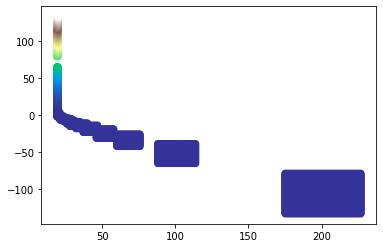

In [473]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

v, x, y, z = [], [], [], []
for v_x0 in range(1, 250):
    y_range = ((-60, 300) if v_x0 < 22 else
               (-100, 10) if v_x0 < 50 else
               (-130, -15) if v_x0 < 160 else
               (-135, -50) if v_x0 < 210 else
               (-140, 0))
    for v_y0 in range(*y_range):
        height_achieved = launch_probe(v_x0, v_y0, target2, max_steps=800)
        if height_achieved is not None:
            x.append(v_x0)
            y.append(v_y0)
            v.append((v_x0, v_y0))
            z.append(height_achieved)

print(len(z))
plt.scatter(x, y, c=z, cmap='terrain')